## Imports and Dataframe Setup

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from scipy.stats import kurtosis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve


In [ ]:
#Making df from Police Sector geometry. Pulling from database messes with the format of coordinates. Easier to use local machine

"""
import pandas as pd
from sqlalchemy import create_engine

# Database credentials
username = 'crimeadmin'
password = '4DAnuuSBWVQ92w!F'
host = 'crimedbmysql.cspoouh9lugd.us-east-2.rds.amazonaws.com'
database = 'crimedb_mysql'
port = '3306'  # default MySQL port

# Create the database engine
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}')

# SQL query or table name
query = "SELECT * FROM Police_Sector_Geom"  #Name of table 

# Create a DataFrame from the SQL query
sector = pd.read_sql(query, engine)
"""

In [ ]:
#Making df from Community areas geometry. Altered in database for some reason. Uploading manually instead from machine

"""
import pandas as pd
from sqlalchemy import create_engine

# Database credentials
username = 'crimeadmin'
password = '4DAnuuSBWVQ92w!F'
host = 'crimedbmysql.cspoouh9lugd.us-east-2.rds.amazonaws.com'
database = 'crimedb_mysql'
port = '3306'  # default MySQL port

# Create the database engine
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}')

# SQL query or table name
query = "SELECT * FROM Cleaned_CommAreas"  #Name of table 

# Create a DataFrame from the SQL query
comm = pd.read_sql(query, engine)
"""

In [3]:
#sector = pd.read_csv('police_sector_geom.csv') #--Emily's path to upload file 
sector = pd.read_csv('/Users/ericchestnut/Documents/GitHub/Crime-Analysis/Chicago Crime ML Notebooks/police_sector_geom')
sector.head(5)

,SECTOR,geometry
0,110,"POLYGON ((-87.6241874583793 41.88882269585851,..."
1,120,POLYGON ((-87.63468593580227 41.86674615377552...
2,130,POLYGON ((-87.60904954502567 41.84726467020776...
3,210,POLYGON ((-87.61678285410099 41.81631294611196...
4,220,POLYGON ((-87.62262194314407 41.80091566144083...


In [4]:
#comm = pd.read_csv('CommAreas.csv') #<---- Emily's path to upload file
comm = pd.read_csv('/Users/ericchestnut/Downloads/CommAreas (2).csv')
comm.head(5)

,the_geom,PERIMETER,AREA,COMAREA_,COMAREA_ID,AREA_NUMBE,COMMUNITY,AREA_NUM_1,SHAPE_AREA,SHAPE_LEN
0,MULTIPOLYGON (((-87.60914087617894 41.84469250...,0,0,0,0,35,DOUGLAS,35,4.600462e+07,31027.054510
1,MULTIPOLYGON (((-87.59215283879394 41.81692934...,0,0,0,0,36,OAKLAND,36,1.691396e+07,19565.506153
2,MULTIPOLYGON (((-87.62879823733725 41.80189303...,0,0,0,0,37,FULLER PARK,37,1.991670e+07,25339.089750
3,MULTIPOLYGON (((-87.6067081256125 41.816813770...,0,0,0,0,38,GRAND BOULEVARD,38,4.849250e+07,28196.837157
4,MULTIPOLYGON (((-87.59215283879394 41.81692934...,0,0,0,0,39,KENWOOD,39,2.907174e+07,23325.167906


In [5]:
sorted_df = comm.sort_values(by='AREA_NUMBE')
sorted_df.head(5)

,the_geom,PERIMETER,AREA,COMAREA_,COMAREA_ID,AREA_NUMBE,COMMUNITY,AREA_NUM_1,SHAPE_AREA,SHAPE_LEN
9,MULTIPOLYGON (((-87.65455590025104 41.99816614...,0,0,0,0,1,ROGERS PARK,1,5.125990e+07,34052.397576
19,MULTIPOLYGON (((-87.6846530946559 42.019484772...,0,0,0,0,2,WEST RIDGE,2,9.842909e+07,43020.689458
30,MULTIPOLYGON (((-87.64102430213292 41.95480280...,0,0,0,0,3,UPTOWN,3,6.509564e+07,46972.794555
5,MULTIPOLYGON (((-87.6744075678037 41.976103404...,0,0,0,0,4,LINCOLN SQUARE,4,7.135233e+07,36624.603085
47,MULTIPOLYGON (((-87.67336415409336 41.93234274...,0,0,0,0,5,NORTH CENTER,5,5.705417e+07,31391.669754


In [6]:
comm.columns

Index(['the_geom', 'PERIMETER', 'AREA', 'COMAREA_', 'COMAREA_ID', 'AREA_NUMBE',
       'COMMUNITY', 'AREA_NUM_1', 'SHAPE_AREA', 'SHAPE_LEN'],
      dtype='object')

## Visualizing Sector and Community Area Map Overlay

In [7]:
import geopandas as gpd
import shapely.wkt


sector = gpd.GeoDataFrame(sector, geometry=gpd.GeoSeries.from_wkt(sector['geometry']))
sector = gpd.GeoDataFrame(sector, geometry='geometry')

comm['the_geom'] = comm['the_geom'].apply(lambda x: shapely.wkt.loads(x.strip()))  # Strip leading/trailing whitespace
comm = gpd.GeoDataFrame(comm, geometry='the_geom')

In [9]:
# Set the CRS for both dataframes
# Set the initial CRS for the DataFrame (e.g., EPSG:4326 for WGS 84)
initial_crs = 'EPSG:4326'

# Set the CRS for the DataFrames
sector.crs = initial_crs
comm.crs = initial_crs

# Define the CRS you want to use for reprojection (e.g., EPSG:3857 for Web Mercator)
desired_crs = 'EPSG:3857'

# Reproject the DataFrame to the desired CRS
sector = sector.to_crs(desired_crs)
comm = comm.to_crs(desired_crs)

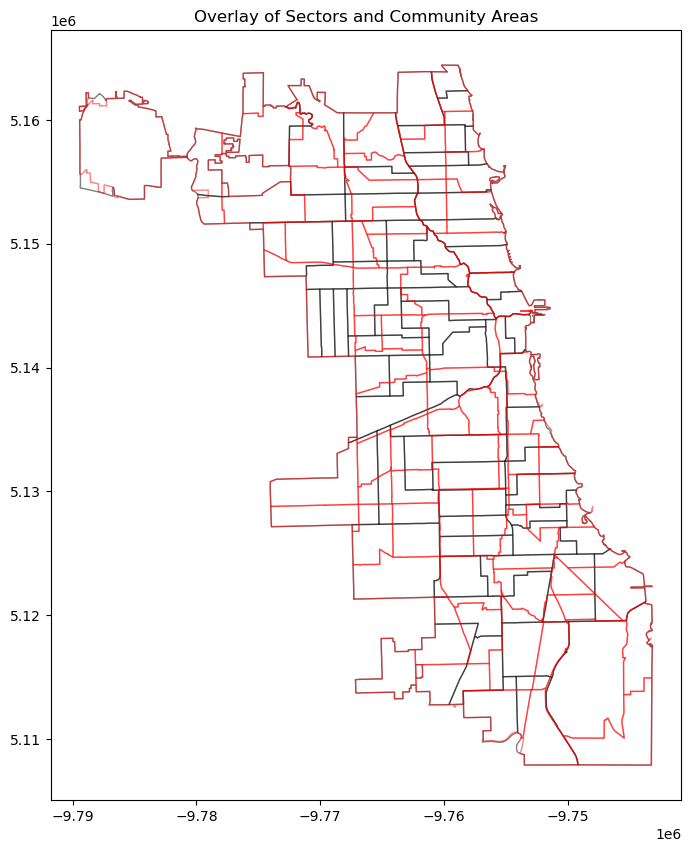

In [10]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed

# Plot the 'sector' dataframe with no fill color
sector.plot(ax=ax, color='none', edgecolor='black', alpha=0.5)  # Only edge color is visible

# Plot the 'comm' dataframe with no fill color
comm.plot(ax=ax, color='none', edgecolor='red', alpha=0.5)  # Only edge color is visible

# Optional: Set additional plot parameters
ax.set_title('Overlay of Sectors and Community Areas')
ax.set_facecolor('white')  # Ensuring the background is white

# Show the plot
plt.show()


## Merging Community Area Geodata onto Census Data

In [11]:

import pandas as pd
from sqlalchemy import create_engine

# Database credentials
username = 'crimeadmin'
password = '4DAnuuSBWVQ92w!F'
host = 'crimedbmysql.cspoouh9lugd.us-east-2.rds.amazonaws.com'
database = 'crimedb_mysql'
port = '3306'  # default MySQL port

# Create the database engine
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}')

# SQL query or table name
query = "SELECT * FROM Cleaned_Census_Data"  #Name of table 

# Create a DataFrame from the SQL query
census = pd.read_sql(query, engine)

In [12]:
census

,id,Community_Area_Number,COMMUNITY_AREA_NAME,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16_UNEMPLOYED,PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX
0,1,1,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39
1,2,2,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46
2,3,3,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20
3,4,4,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17
4,5,5,North Center,0.3,7.5,5.2,4.5,26.2,57123,6
...,...,...,...,...,...,...,...,...,...,...
73,74,74,Mount Greenwood,1.0,3.4,8.7,4.3,36.8,34381,16
74,75,75,Morgan Park,0.8,13.2,15.0,10.8,40.3,27149,30
75,76,76,O'Hare,3.6,15.4,7.1,10.9,30.3,25828,24
76,77,77,Edgewater,4.1,18.2,9.2,9.7,23.8,33385,19


In [13]:
merged_df = comm.merge(census, left_on='AREA_NUMBE', right_on='Community_Area_Number', how='left')

In [14]:
merged_df.head(5)

,the_geom,PERIMETER,AREA,COMAREA_,COMAREA_ID,AREA_NUMBE,COMMUNITY,AREA_NUM_1,SHAPE_AREA,SHAPE_LEN,id,Community_Area_Number,COMMUNITY_AREA_NAME,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16_UNEMPLOYED,PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX
0,"MULTIPOLYGON (((-9752604.951 5137743.450, -975...",0,0,0,0,35,DOUGLAS,35,4.600462e+07,31027.054510,35,35,Douglas,1.8,29.6,18.2,14.3,30.7,23791,47
1,"MULTIPOLYGON (((-9750713.852 5133595.674, -975...",0,0,0,0,36,OAKLAND,36,1.691396e+07,19565.506153,36,36,Oakland,1.3,39.7,28.7,18.4,40.4,19252,78
2,"MULTIPOLYGON (((-9754793.199 5131350.020, -975...",0,0,0,0,37,FULLER PARK,37,1.991670e+07,25339.089750,37,37,Fuller Park,3.2,51.2,33.9,26.6,44.9,10432,97
3,"MULTIPOLYGON (((-9752334.139 5133578.410, -975...",0,0,0,0,38,GRAND BOULEVARD,38,4.849250e+07,28196.837157,38,38,Grand Boulevard,3.3,29.3,24.3,15.9,39.5,23472,57
4,"MULTIPOLYGON (((-9750713.852 5133595.674, -975...",0,0,0,0,39,KENWOOD,39,2.907174e+07,23325.167906,39,39,Kenwood,2.4,21.7,15.7,11.3,35.4,35911,26


In [15]:
columns_to_drop = ['PERIMETER', 'AREA', 'COMAREA_', 'COMAREA_ID', 'AREA_NUMBE', 'AREA_NUM_1', 'SHAPE_AREA', 'SHAPE_LEN','id']
merged_df = merged_df.drop(columns=columns_to_drop, axis=1)

#merged_df = merged_df.rename(columns={'the_geom': 'geometry'})

merged_df = merged_df.sort_values(by='Community_Area_Number').reset_index(drop=True)

In [16]:
merged_df.head(5)

,the_geom,COMMUNITY,Community_Area_Number,COMMUNITY_AREA_NAME,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16_UNEMPLOYED,PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX
0,"MULTIPOLYGON (((-9757660.529 5160704.746, -975...",ROGERS PARK,1,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39
1,"MULTIPOLYGON (((-9761010.933 5163898.616, -976...",WEST RIDGE,2,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46
2,"MULTIPOLYGON (((-9756154.198 5154211.526, -975...",UPTOWN,3,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20
3,"MULTIPOLYGON (((-9759870.406 5157400.522, -975...",LINCOLN SQUARE,4,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17
4,"MULTIPOLYGON (((-9759754.254 5150850.097, -975...",NORTH CENTER,5,North Center,0.3,7.5,5.2,4.5,26.2,57123,6


## Merging Community Area and Census Data

### Joining based on which community area is closest

In [17]:
"""

# Perform the nearest join
initial_crs = 'EPSG:4326'

# Set the CRS for the DataFrames
merged_df.crs = initial_crs

# Define the CRS you want to use for reprojection (e.g., EPSG:3857 for Web Mercator)
desired_crs = 'EPSG:3857'

# Reproject the DataFrame to the desired CRS
merged_df = merged_df.to_crs(desired_crs)
"""

joined_df = gpd.sjoin_nearest(sector, merged_df, how='left')

In [18]:
joined_df.head(5)

,SECTOR,geometry,index_right,COMMUNITY,Community_Area_Number,COMMUNITY_AREA_NAME,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16_UNEMPLOYED,PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX
0,110,"POLYGON ((-9754279.929 5144340.144, -9754262.6...",32,NEAR SOUTH SIDE,33,Near South Side,1.3,13.8,4.9,7.4,21.8,59077,7
0,110,"POLYGON ((-9754279.929 5144340.144, -9754262.6...",31,LOOP,32,Loop,1.5,14.7,5.7,3.1,13.5,65526,3
0,110,"POLYGON ((-9754279.929 5144340.144, -9754262.6...",7,NEAR NORTH SIDE,8,Near North Side,1.9,12.9,7.0,2.5,22.6,88669,1
1,120,"POLYGON ((-9755448.614 5141039.517, -9755449.7...",32,NEAR SOUTH SIDE,33,Near South Side,1.3,13.8,4.9,7.4,21.8,59077,7
1,120,"POLYGON ((-9755448.614 5141039.517, -9755449.7...",31,LOOP,32,Loop,1.5,14.7,5.7,3.1,13.5,65526,3


### Joining based on which community area shares the most area with sector

In [19]:
def max_overlap_join(target_df, source_df):
    joined_df = target_df.copy()
    for idx, row in target_df.iterrows():
        # Calculate intersection areas
        intersections = source_df.intersection(row['geometry']).area
        # Find the index with the maximum intersection area
        max_idx = intersections.idxmax()
        # Join data from source_df to target_df
        for col in source_df.columns:
            joined_df.at[idx, col] = source_df.at[max_idx, col]
    return joined_df

result_df = max_overlap_join(sector, merged_df)

In [20]:
#Converting Community Area to int
result_df['Community_Area_Number'] = result_df['Community_Area_Number'].astype(int)
result_df.head(5)

,SECTOR,geometry,the_geom,COMMUNITY,Community_Area_Number,COMMUNITY_AREA_NAME,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16_UNEMPLOYED,PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX
0,110,"POLYGON ((-9754279.929 5144340.144, -9754262.6...",MULTIPOLYGON (((-9752643.348235618 5144426.338...,LOOP,32,Loop,1.5,14.7,5.7,3.1,13.5,65526.0,3.0
1,120,"POLYGON ((-9755448.614 5141039.517, -9755449.7...",MULTIPOLYGON (((-9755771.713460958 5143953.073...,NEAR WEST SIDE,28,Near West Side,3.8,20.6,10.7,9.6,22.2,44689.0,15.0
2,130,"POLYGON ((-9752594.784 5138127.819, -9752557.8...",MULTIPOLYGON (((-9752604.95117241 5137743.4497...,NEAR SOUTH SIDE,33,Near South Side,1.3,13.8,4.9,7.4,21.8,59077.0,7.0
3,210,"POLYGON ((-9753455.652 5133503.605, -9753454.9...",MULTIPOLYGON (((-9752604.95117241 5137743.4497...,DOUGLAS,35,Douglas,1.8,29.6,18.2,14.3,30.7,23791.0,47.0
4,220,"POLYGON ((-9754105.657 5131204.069, -9754103.2...",MULTIPOLYGON (((-9750713.851501133 5133595.673...,KENWOOD,39,Kenwood,2.4,21.7,15.7,11.3,35.4,35911.0,26.0


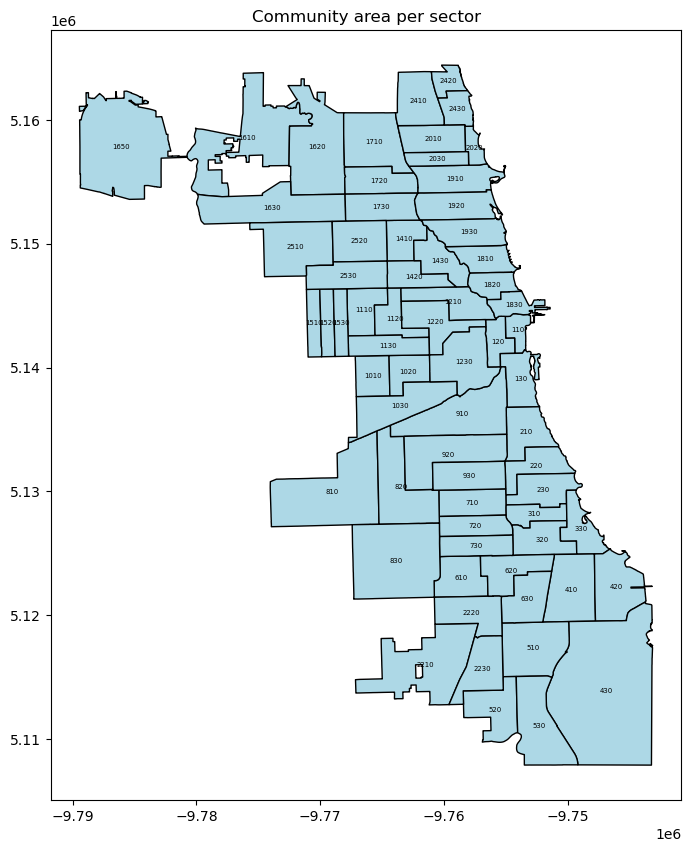

In [21]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 10))
result_df.plot(ax=ax, color='lightblue', edgecolor='black')

# Add labels
for idx, row in result_df.iterrows():
    # Extract the centroid of the polygon
    centroid = row.geometry.centroid
    # Annotate with the SECTOR value
    ax.annotate(text=str(row['SECTOR']), xy=(centroid.x, centroid.y),
                horizontalalignment='center', verticalalignment='center', fontsize=5, color='black')

# Customize the plot
ax.set_title('Community area per sector')
plt.show()


## Visuals to Confirm if Joining was Accurate

In [ ]:
"""
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 10))
result_df.plot(ax=ax, color='lightblue', edgecolor='black')

# Add labels
for idx, row in result_df.iterrows():
    # Extract the centroid of the polygon
    centroid = row.geometry.centroid
    # Annotate with the SECTOR value
    ax.annotate(text=str(row['Community_Area_Number']), xy=(centroid.x, centroid.y),
                horizontalalignment='center', verticalalignment='center', fontsize=5, color='black')

# Customize the plot
ax.set_title('Community area per sector')
plt.show()
"""

In [ ]:
"""

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 10))
merged_df.plot(ax=ax, color='lightblue', edgecolor='black')

# Add labels
for idx, row in merged_df.iterrows():
    # Extract the centroid of the polygon
    centroid = row.the_geom.centroid
    # Annotate with the SECTOR value
    ax.annotate(text=str(row['Community_Area_Number']), xy=(centroid.x, centroid.y),
                horizontalalignment='center', verticalalignment='center', fontsize=5, color='black')

# Customize the plot
ax.set_title('Community area per sector')
plt.show()
"""

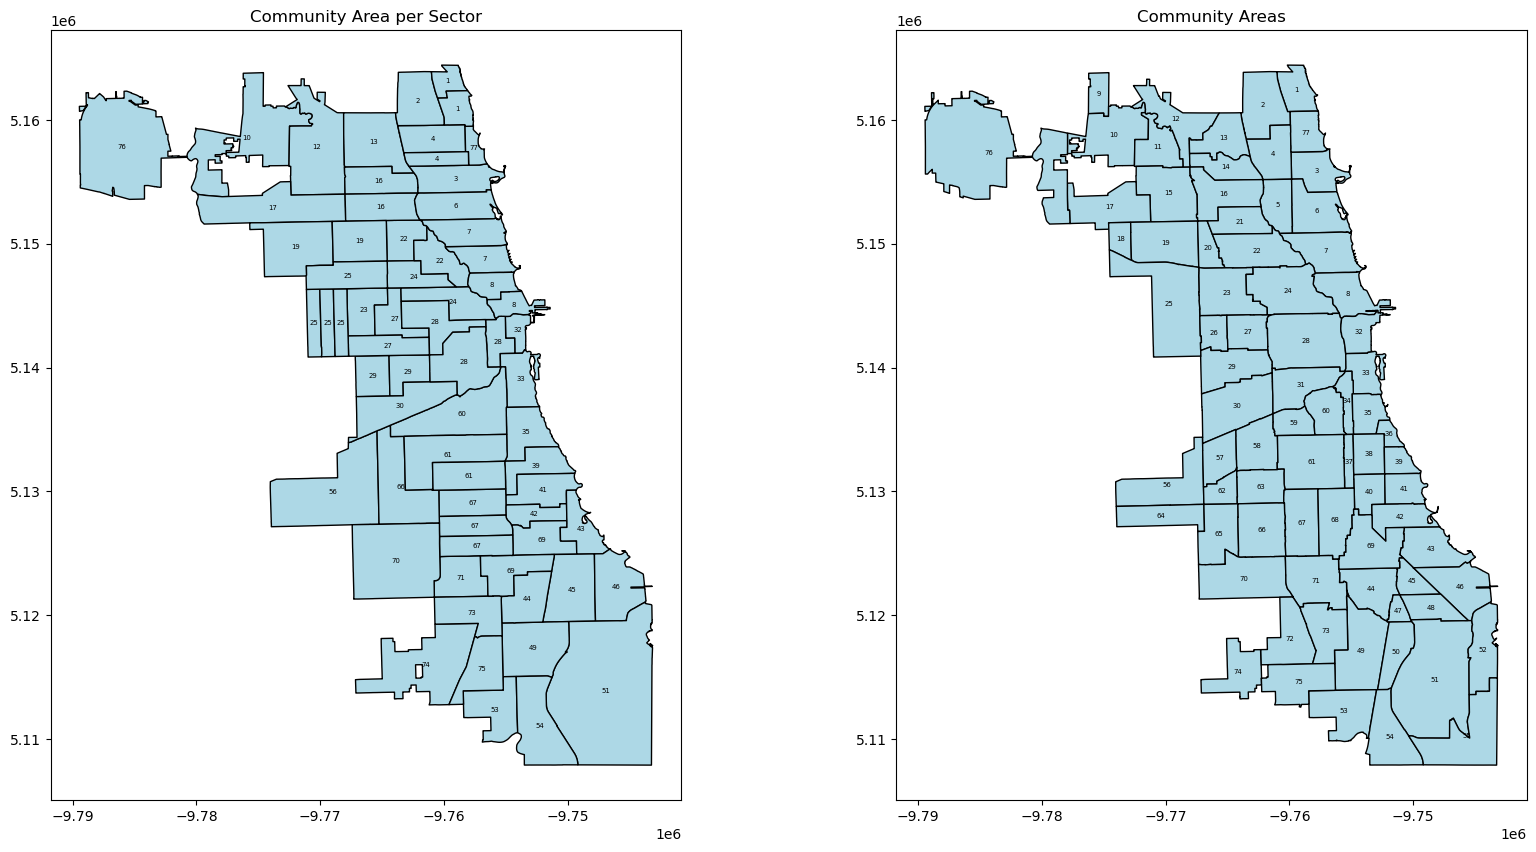

In [22]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plotting the first data (result_df)
result_df.plot(ax=ax1, color='lightblue', edgecolor='black')
# Add labels for result_df
for idx, row in result_df.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(text=str(row['Community_Area_Number']), xy=(centroid.x, centroid.y),
                 horizontalalignment='center', verticalalignment='center', fontsize=5, color='black')
# Customize the first plot
ax1.set_title('Community Area per Sector')

# Plotting the second data (merged_df)
merged_df.plot(ax=ax2, color='lightblue', edgecolor='black')
# Add labels for merged_df
for idx, row in merged_df.iterrows():
    centroid = row.the_geom.centroid
    ax2.annotate(text=str(row['Community_Area_Number']), xy=(centroid.x, centroid.y),
                 horizontalalignment='center', verticalalignment='center', fontsize=5, color='black')
# Customize the second plot
ax2.set_title('Community Areas')

# Display the figure
plt.show()

## Joining onto Regression Model

In [23]:
import pandas as pd
from sqlalchemy import create_engine

# Database credentials
username = 'crimeadmin'
password = '4DAnuuSBWVQ92w!F'
host = 'crimedbmysql.cspoouh9lugd.us-east-2.rds.amazonaws.com'
database = 'crimedb_mysql'
port = '3306'  # default MySQL port

# Create the database engine
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}')

# SQL query or table name
query = "SELECT * FROM TIME_SERIES_REGRESSION_3"  #Name of table 

# Create a DataFrame from the SQL query
df_violent = pd.read_sql(query, engine)

In [24]:
#Changing Column name for joining
result_df = result_df.rename(columns={'SECTOR': 'Sector'})

In [25]:
# Perform a left join
merged_df = df_violent.merge(result_df, on='Sector', how='left')


In [26]:
merged_df.columns

Index(['Sector', 'Month', 'Violent Crimes', 'SAFETY', 'S_EDUCATION_LOW',
       'S_EDUCATION_MEDIUM', 'S_EDUCATION_HIGH', 'S_INCOME_LOW',
       'S_INCOME_MEDIUM', 'S_INCOME_HIGH', 'TRUST', 'T_EDUCATION_LOW',
       'T_EDUCATION_MEDIUM', 'T_EDUCATION_HIGH', 'T_INCOME_LOW',
       'T_INCOME_MEDIUM', 'T_INCOME_HIGH', 'TOTAL POPULATION',
       'Population Density (people/sqkm)', 'Violent Crimes per Capita',
       'Units', 'Units per SqKm', 'Units per Capita', 'geometry', 'the_geom',
       'COMMUNITY', 'Community_Area_Number', 'COMMUNITY_AREA_NAME',
       'PERCENT_OF_HOUSING_CROWDED', 'PERCENT_HOUSEHOLDS_BELOW_POVERTY',
       'PERCENT_AGED_16_UNEMPLOYED',
       'PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA',
       'PERCENT_AGED_UNDER_18_OR_OVER_64', 'PER_CAPITA_INCOME',
       'HARDSHIP_INDEX'],
      dtype='object')

In [27]:
merged_df.head(5)

,Sector,Month,Violent Crimes,SAFETY,S_EDUCATION_LOW,S_EDUCATION_MEDIUM,S_EDUCATION_HIGH,S_INCOME_LOW,S_INCOME_MEDIUM,S_INCOME_HIGH,...,COMMUNITY,Community_Area_Number,COMMUNITY_AREA_NAME,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16_UNEMPLOYED,PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX
0,110,2017-11,66,68.23,NaN,NaN,NaN,NaN,NaN,NaN,...,LOOP,32,Loop,1.5,14.7,5.7,3.1,13.5,65526.0,3.0
1,110,2017-12,52,65.67,NaN,NaN,NaN,NaN,NaN,NaN,...,LOOP,32,Loop,1.5,14.7,5.7,3.1,13.5,65526.0,3.0
2,110,2018-01,74,72.35,NaN,NaN,NaN,NaN,NaN,NaN,...,LOOP,32,Loop,1.5,14.7,5.7,3.1,13.5,65526.0,3.0
3,110,2018-02,73,75.66,NaN,NaN,NaN,NaN,NaN,NaN,...,LOOP,32,Loop,1.5,14.7,5.7,3.1,13.5,65526.0,3.0
4,110,2018-03,84,73.90,62.18,78.27,74.8,65.28,78.7,73.23,...,LOOP,32,Loop,1.5,14.7,5.7,3.1,13.5,65526.0,3.0


## Visualizing Violent Crimes by Sector

For some reason when I used the columns in the dataframe, my aggregate wasn't working and I was getting low numbers like 200 for a community area over a span of 5 years. So I had to reload police sector file and rejoin. When I did that the numbers came in as expected. 

In [28]:
# Create a copy of merged_df
merged_df_copy = merged_df.copy()

# Aggregate violent crimes by sector
crime_by_sector = merged_df_copy.groupby('Sector')['Violent Crimes'].sum().reset_index()

# Reload police sector geographical data
police_sector_geom_path = 'police_sector_geom.csv' #<------Update file path 
police_sector_geom = pd.read_csv(police_sector_geom_path)

# Convert the geometry column from WKT to a geometry object
police_sector_geom['geometry'] = police_sector_geom['geometry'].apply(loads)
gdf_sectors = gpd.GeoDataFrame(police_sector_geom, geometry='geometry')

# Merge the aggregated crime data with the geographical data
gdf_sectors = gdf_sectors.merge(crime_by_sector, left_on='SECTOR', right_on='Sector', how='left')

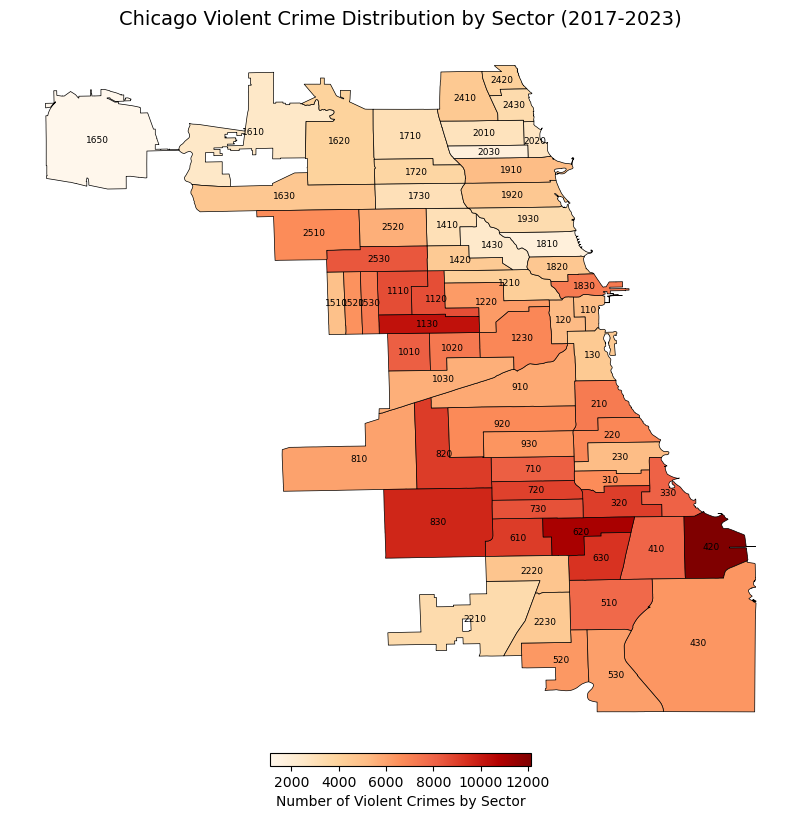

In [57]:
#Create the density heatmap for violent crimes by sector
fig, ax_main = plt.subplots(1, 1, figsize=(9, 9))
gdf_sectors.plot(column='Violent Crimes', ax=ax_main, legend=True,
                         legend_kwds={'label': "Number of Violent Crimes by Sector",
                                      'orientation': "horizontal", 'shrink': 0.3, 'pad': 0.01},
                         cmap='OrRd', edgecolor='black', linewidth=0.5) 

# Add sector numbers with adjusted font size and position
for idx, row in gdf_sectors.iterrows():
    plt.annotate(text=row['SECTOR'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', verticalalignment='center', fontsize=6.5, color='black')

# Remove axis for main map
ax_main.set_axis_off()
ax_main.set_title("Chicago Violent Crime Distribution by Sector (2017-2023)", fontsize=14)
# Tight layout to minimize white space
plt.tight_layout()
plt.show()

## Visualizing Violent Crimes by Community Areas

*NOTE: This doesn't end up working because the sectors don't bring in all the community areas. When aggregated, we had a lot of community areas with null values. When I try to pull it from the dataframe itself, I get very low violent crime counts for some reason like in the 200s which made me relook at my numbers.

In [29]:
# Aggregate violent crimes by sector
crime_by_comm_areas = merged_df_copy.groupby('Community_Area_Number')['Violent Crimes'].sum().reset_index()
# Reload police sector geographical data (had to rejoin, for some reason violent crime counts didn't aggregate correctly and were very low)
comm_areas_geom_path = 'CommAreas.csv'
comm_areas_geom = pd.read_csv(comm_areas_geom_path)  #<------Update file path 

# Convert geometry
comm_areas_geom['geometry'] = comm_areas_geom['the_geom'].apply(loads)
gdf_comm_areas = gpd.GeoDataFrame(comm_areas_geom, geometry='geometry')

# Merge the aggregated crime data with the geographical data
gdf_comm_areas = gdf_comm_areas.merge(crime_by_comm_areas , left_on='AREA_NUM_1', right_on='Community_Area_Number', how='left')

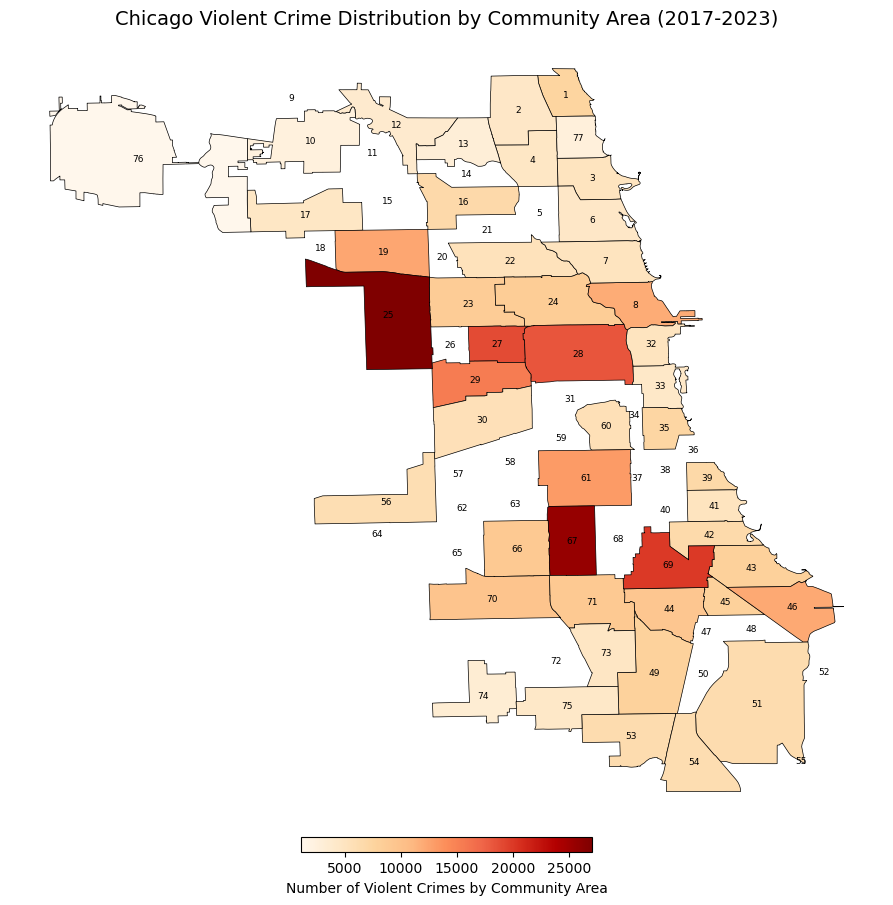

In [30]:
 # Plot the density heatmap for violent crimes by community area
fig, ax_main = plt.subplots(1, 1, figsize=(10, 10))
gdf_comm_areas.plot(column='Violent Crimes', ax=ax_main, legend=True,
                    legend_kwds={'label': "Number of Violent Crimes by Community Area",
                                 'orientation': "horizontal", 'shrink': 0.3, 'pad': 0.01},
                    cmap='OrRd', edgecolor='black', linewidth=0.5)
# Add community area numbers with adjusted font size and position
for idx, row in gdf_comm_areas.iterrows():
    plt.annotate(text=str(row['AREA_NUM_1']), xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', verticalalignment='center', fontsize=6.5, color='black')

# Remove axis for main map
ax_main.set_axis_off()
ax_main.set_title("Chicago Violent Crime Distribution by Community Area (2017-2023)", fontsize=14)

# Tight layout to minimize white space
plt.tight_layout()
plt.show()

## Drop Columns and Upload to Database

In [31]:
# List of columns to drop
columns_to_drop = ['COMMUNITY','COMMUNITY_AREA_NAME',
                   'geometry', 'the_geom','Community_Area_Number',
       ] 

# Dropping the columns from the DataFrame
merged_df = merged_df.drop(columns=columns_to_drop, axis=1)

In [ ]:
#Uploading new dataset
from sqlalchemy import create_engine

# Create the database engine
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}/{database}')

# Specify the new table name here
new_table_name = 'TIME_SERIES_REGRESSION_5'

# Upload the dataframe to the new table
merged_df.to_sql(new_table_name, con=engine, if_exists='replace', index=False)